In [ ]:
import os
import subprocess

target_dir = "/data/projects/nckf/frekle/obs_data"
os.makedirs(target_dir, exist_ok=True)
os.chdir(target_dir)

base_url = "http://www.metoffice.gov.uk/hadobs/en4/data/en4-2-1/EN.4.2.2"

for year in range(1900, 2026):
    fname = f"EN.4.2.2.analyses.c14.{year}.zip"
    url = f"{base_url}/{fname}"
    print(f"⬇️ Downloading {year} ...")
    subprocess.run(["wget", "-q", "-O", fname, url])
    subprocess.run(["unzip", "-o", fname], stdout=subprocess.DEVNULL)
    os.remove(fname)

print("✅ All EN4 analysis files downloaded and extracted.")


/tmp/ipykernel_589045/1538399306.py:18: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  en4_time = xr.cftime_range(start="1900", periods=len(en4.time), freq="M")
/tmp/ipykernel_589045/1538399306.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.
  en4_time = xr.cftime_range(start="1900", periods=len(en4.time), freq="M")
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Loading EC-Earth3 members:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_589045/1538399306.py:44: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  time = xr.cftime_range(start="1850", periods=len(ds.time), freq="Y")
/tmp/ipykernel_589045/1538399306.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  

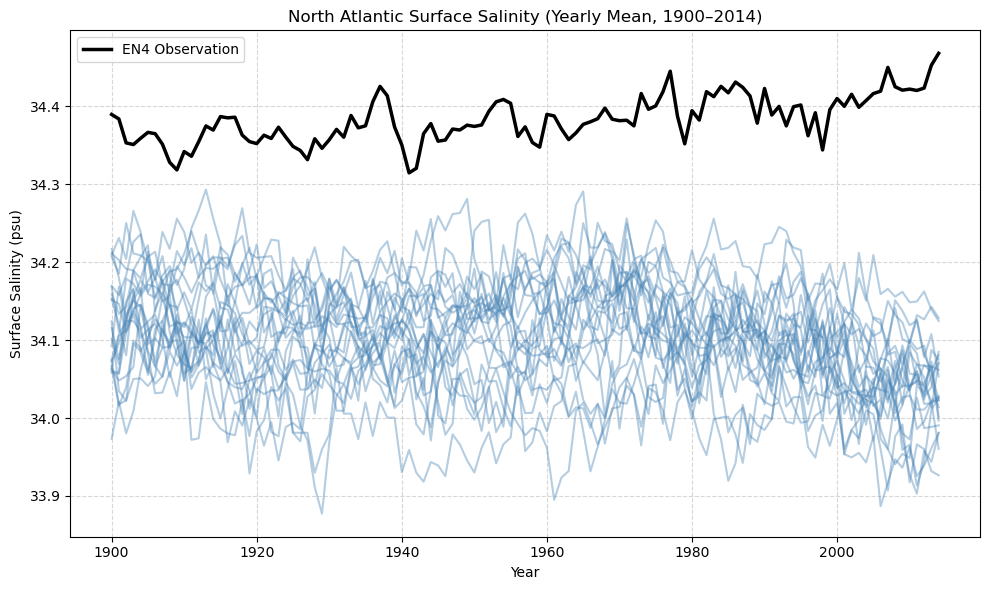

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

# -----------------------------
# File paths
# -----------------------------
data_dir = "/data/projects/nckf/frekle/CMIP6_data/so/"
en4_path = f"{data_dir}EN4_SSS_surface_1900_2014_Atl.nc"
model_pattern = f"{data_dir}so_masked_r*i1p1f1.nc"  # 21 members

# -----------------------------
# Load EN4 observations
# -----------------------------
en4 = xr.open_dataset(en4_path)
en4_time = xr.cftime_range(start="1900", periods=len(en4.time), freq="M")
en4 = en4.assign_coords(time=en4_time)

# Mask to North Atlantic (lat 0–70°N)
if "latitude" in en4:
    en4 = en4.where((en4.latitude > 0) & (en4.latitude < 70), drop=True)

# Compute mean over area (already Atlantic-masked)
en4_mean = en4["salinity_masked"].mean(dim=("j", "i"), skipna=True)

# Convert to yearly mean
en4_yearly = en4_mean.resample(time="Y").mean()

# -----------------------------
# Load EC-Earth3 ensemble members
# -----------------------------
model_files = sorted(glob.glob(model_pattern))
member_means = []

for f in tqdm(model_files, desc="Loading EC-Earth3 members"):
    ds = xr.open_dataset(f)
    
    # Take surface level
    so_surface = ds["so"].isel(lev=0)
    
    # Create proper time axis
    time = xr.cftime_range(start="1850", periods=len(ds.time), freq="Y")
    so_surface = so_surface.assign_coords(time=time)
    
    # Restrict to 1900–2014
    so_surface = so_surface.sel(time=slice("1900", "2014"))
    
    # Mask to North Atlantic (lat 0–70°N)
    if "latitude" in so_surface:
        so_surface = so_surface.where((so_surface.latitude > 0) & (so_surface.latitude < 70), drop=True)
    
    # Area mean
    so_mean = so_surface.mean(dim=("j", "i"), skipna=True)
    
    # Yearly mean (model is already yearly, but this keeps structure consistent)
    so_yearly = so_mean.resample(time="Y").mean()
    
    member_means.append(so_yearly)

# Combine into one dataset
model_yearly = xr.concat(member_means, dim="member")
model_yearly["member"] = np.arange(1, len(model_files)+1)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,6))

# Plot all ensemble members
for i in range(len(model_yearly.member)):
    plt.plot(model_yearly.time.dt.year, model_yearly.isel(member=i), color="steelblue", alpha=0.4)

# Plot EN4 observation
plt.plot(en4_yearly.time.dt.year, en4_yearly, color="black", lw=2.5, label="EN4 Observation")

plt.xlabel("Year")
plt.ylabel("Surface Salinity (psu)")
plt.title("North Atlantic Surface Salinity (Yearly Mean, 1900–2014)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()






In [ ]:
# Select surface (first depth level)
sss = en4["salinity"].isel(depth=0)

# Optional: restrict time range (e.g., 1900–2014)
sss = sss.sel(time=slice("1900-01", "2014-12"))

# Save a compact file
out_path = os.path.join(data_dir, "EN4_SSS_surface_1900_2014.nc")
sss.to_netcdf(out_path)

print(f"✅ Saved merged surface salinity to {out_path}")
